In [1]:
## Import system library
import os
import glob

## Import Image Processing library
import cv2
import numpy as np
import skimage
from skimage import exposure
from skimage.color import rgb2gray
from scipy.ndimage import convolve, uniform_filter
from skimage.filters import gabor_kernel, unsharp_mask, threshold_otsu, gabor
from skimage.morphology import disk, closing, dilation
import torchvision.models as models
import matplotlib.pyplot as plt
%matplotlib inline

## Import machine learning library
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from utils.lbp import LBP
from utils.vis import draw_bboxes
from utils.preprocess import sliding_window
from utils.dataset import load_yolo_labels
from utils.bboxes import iou, calculate_boxA_percentage
from utils.intensity_transforms import histogram_matching, calculate_mean_histogram
from utils.dataset import adjust_labels_for_pooling, resize_image_and_bboxes
from models.kernels import AlexNetDescriptor

In [2]:
## Defind dataset folders

# root_path = '/content/drive/Shareddrives/Wrist_fracture_detectiom/ML/Dataset'
root_path = 'MLDataset/crop_data'

img_train_folder = 'train'
img_test_folder = 'test'
label_folder = 'labels'
image_folder = 'images'

In [3]:
def export_features(export_path, name, feature_name, feature_list):
    """Save features to npy file

    Args:
        export_path (str): path to save the file
        name (str): file name to save
        feature_name (str): name of the feature. Ex: 'lbp', 'hog', 'gabor'
        feature_list (list/array): list of features
    """
    ## Export features to file
    save_name = f'{name}_{feature_name}.npy'
    save_path = os.path.join(export_path, save_name)
    np.save(save_path, feature_list)
    print(f'Save {feature_name} features to {save_path}')

## Histogram Matching

In [4]:
import glob

## Calculate mean histogram
image_files = glob.glob(os.path.join(root_path, image_folder, 'train/**/*.png'), recursive=True)
mean_histogram = calculate_mean_histogram(image_files)

In [5]:
### Extract mean histogram from the training dataset
np.save('mean_hist.npy', mean_histogram)

In [ ]:
## Apply histogram matching for each image
for i, image_file in enumerate(image_files):
    if i > 1:
        break
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    matched_img = histogram_matching(image, mean_histogram)
    ax, fig = plt.subplots(1, 2, figsize=(10, 5))
    fig[0].imshow(image)
    fig[1].imshow(matched_img)
    plt.show()

## Processing


In [57]:
def preprocess(image, mean_histogram=None, dilate_num=4, intensity_crop=1, outputbitdepth=8, unsharp=True):
    """
    Processes a single image by applying histogram matching, thresholding,
    multiple dilations, and closing.

    Args:
    - image_path (str/numpy): Path to the image file or numpy array of the image.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - dilate_num (int): Number of times dilation should be applied.
    - intensity_crop (int): Percentage of the image intensity to crop.
    - outputbitdepth (int): The bit depth of the output image.

    Returns:
    - final_image (ndarray): The processed image.
    """
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")
    
    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    image = exposure.equalize_adapthist(image)

    
    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)
    
    # Apply the mask to the original image using a bitwise AND operation
    final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))
    
    return final_image


In [58]:
def process_image_and_labels(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, pool_size=(4,4), resize=None):
    """
    Processes an image by preprocessing and loading corresponding labels, then applies pooling.

    Args:
    image_path (str): Path to the image file.
    mean_histogram (bool): Flag for histogram processing.
    intensity_crop (tuple): Intensity cropping parameters.
    outputbitdepth (int): Bit depth for image output.
    unsharp (bool): Flag for unsharp mask processing.
    pool_size (tuple): Size of the pooling window.

    Returns:
    tuple: A tuple containing the processed image and associated labels.
    """
    labels = []
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    ### Parse label
    image_name = os.path.basename(image_path)
    label_path = image_path.replace('images', 'labels').replace('.png', '.txt')
    if os.path.exists(label_path):
        labels = load_yolo_labels(label_path, img.shape, [3]) # 3 is the class index for fracture
    
    ## Segment bones
    img = preprocess(img, mean_histogram=mean_histogram, intensity_crop=intensity_crop, outputbitdepth=outputbitdepth, unsharp=unsharp)
    
    # Apply pooling
    if pool_size is not None:
        img = skimage.measure.block_reduce(img, pool_size, np.max)
        # Adjust labels for pooling
        labels = adjust_labels_for_pooling(labels, img.shape, pool_size)
    if resize:
        img, labels = resize_image_and_bboxes(img, labels, resize)
        
    return img, labels

## Extract Features

In [425]:
import skimage.measure

probability_heatmap = np.load('./MLDataset/crop_heatmap.npy')
# Thresholding the image to segment the heatmap
_, segmented_image = cv2.threshold(probability_heatmap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
crop_crowd_roi = np.array([cv2.boundingRect(contour) for contour in contours][-1])/probability_heatmap.shape[0]
crop_crowd_roi = np.array([crop_crowd_roi[0], crop_crowd_roi[1], crop_crowd_roi[0]+crop_crowd_roi[2], crop_crowd_roi[1]+crop_crowd_roi[3]])

GET_HARD_SAMPLES = False

def feature_extraction(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, descriptor, stepSize=128, windowSize=256, pool_size=(4, 4), heatmap=None):
    """
    Extract features from an image using a given descriptor.

    Args:
    - image_path (str): Path to the image file.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - intensity_crop (int): Percentage of the image intensity to crop.
    - outputbitdepth (int): The bit depth of the output image.
    - unsharp (bool): Flag for unsharp mask processing.
    - descriptor (object): The descriptor object to use for feature extraction.
    - show_grid (bool): Flag to show the grid of windows.

    Returns:
    - features (list): List of features extracted from the image.
    - labels_list (list): List of labels for each feature.
    """
    features = []
    labels_list = []
    image, labels = process_image_and_labels(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, pool_size)
    ## scale heatmap to the same size as the image
    if heatmap is not None:
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    
    # feature_image = image     

    for i, (x, y, window_f) in enumerate(sliding_window(image, stepSize=stepSize, windowSize=windowSize)):
        if window_f.shape[0] != windowSize or window_f.shape[1] != windowSize:
            continue
        # ## Image histogram 
        window_f = skimage.measure.block_reduce(window_f, (2, 2), np.max)
        feature_image = descriptor(window_f)     
        feature = feature_image.ravel()
        if heatmap is not None:
            feature = np.append(feature, heatmap[y:y+windowSize, x:x+windowSize].ravel())
        
        iou_score = 0
        class_id = 0
        for label in labels:
            c, *xyxy = label
            iou_score = calculate_boxA_percentage(xyxy, [x, y, x + windowSize, y + windowSize])
            if iou_score > 0.5:
                class_id = 1
            elif iou_score > 0.1 and iou_score < 0.5:
                class_id = 0

        # if GET_HARD_SAMPLES:
        #     crop_crowd_roi_scaled = crop_crowd_roi * np.array([image.shape[1], image.shape[0], image.shape[1], image.shape[0]])
        #     area_percentage = calculate_boxA_percentage([x, y, x + windowSize, y + windowSize], crop_crowd_roi_scaled)
        #     if area_percentage < 0.5:
        #         continue
        
        features.append(feature)
        labels_list.append(class_id)

            
    return features, labels_list

In [426]:
windowSize = 64
stepSize = 32
pool_size = (4, 4)
# Parameters for LBP
num_points = 8  # Typically 8, 16, or 24
radius = 3       # Typical values are 1, 2, or 3
background_removal_threshold = 30 # Threshold for removing background in percentage

In [427]:
convert_grayscale = False
outputbitdepth = 8 # Set output bit depth
unsharp = True # Sharpen image
convert_grayscale = False # Convert to grayscale
equalize = True # CLAHE contrast enhancement
intensity_crop = 0.1 # Set rescale intensity crop

### LBP

In [19]:
### Extract LBP features and export to npy file
mode = 'test'
class_name = 'normal'
export_path_fracture = os.path.join(root_path, f'{mode}_{class_name}_lbp.npy')
export_path_non_fracture = os.path.join(root_path, f'{mode}_non_{class_name}_lbp.npy')
export_path_normal = os.path.join(root_path, f'{mode}_normal_lbp.npy')

fracture_features = []
non_fracture_features = []

### Local Binary Pattern
lbp = LBP(num_points, radius)
### Histogram of Oriented Gradients
hog = cv2.HOGDescriptor()
        

### Loop through all images
for idx, image_path in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    print(f"Processing {image_path}")
    if len(fracture_features) >= num_features and len(non_fracture_features) >= num_features:
        break
    
    ### Extract LBP features
    image, labels = process_image_and_labels(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, fracture=True if class_name == 'fracture' else False)
    
    # Use sliding window to generate windows
    windows = list(sliding_window(image, stepSize=stepSize, windowSize=windowSize))
    num_windows = len(windows)
    
    if show_grid:
        # Determine the grid size
        grid_size = int(np.ceil(np.sqrt(num_windows)))
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(20, 20))
    
    for i, (x, y, window_img) in enumerate(sliding_window(image, stepSize=stepSize, windowSize=windowSize)):
        if window_img.shape[0] != windowSize or window_img.shape[1] != windowSize:
            continue
        # ## Image histogram 
        # hist, bins = np.histogram(window_img.flatten(), bins=256, range=[0, 256])
        # lbp_features = lbp.get_lbp_image(window_img)
        hog_features = hog.compute(window_img)
        # lbp_features = lbp_features.ravel()
        hog_features = hog_features.ravel()
        
        # combined_features = np.concatenate([lbp_features, hog_features])
        # combined_features = combined_features.astype(np.float32)
        
        is_fracture = False
        for label in labels:
            c, *xyxy = label
            iou_score = calculate_boxA_percentage(xyxy, [x, y, x + windowSize, y + windowSize])
            if iou_score > 0.8:
                if len(fracture_features) < num_features:
                    fracture_features.append(hog_features)
                is_fracture = True
                break
        if show_grid:
            # Plot the window
            ax[i // grid_size, i % grid_size].imshow(window_img, cmap='gray')
            ax[i // grid_size, i % grid_size].title.set_text(f'{iou_score:.2}' + (' Fracture' if is_fracture else ' Non-Fracture'))
            ax[i // grid_size, i % grid_size].axis('off')
    
        if is_fracture == False:
            non_fracture_features.append(hog_features)
            
    if show_grid:
        # Turn off any unused subplots
        for j in range(i + 1, grid_size * grid_size):
            ax[j // grid_size, j % grid_size].title.set_text('Unused')
            ax[j // grid_size, j % grid_size].axis('off')
        
        plt.show()
        if idx > 10:
            break

Processing MLDataset/crop_data/images/test/normal/0045_0661159881_01_WRI-L1_M010.png


TypeError: process_image_and_labels() got an unexpected keyword argument 'fracture'

In [ ]:
from models.kernels import LBPDescriptor
    
lpb = LBPDescriptor(num_points, radius)

modes = ['train', 'test']
class_names = ['fracture', 'normal']

for mode in modes:
    for class_name in class_names:
        features_list = []
        labels_list = []
        image_files = glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))
        ### Loop through all images
        for idx, image_path in enumerate(image_files):
            print(f"Processing {idx}/{len(image_files)} : {image_path}")
            features, labels = feature_extraction(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp, lpb, stepSize=stepSize, windowSize=windowSize)
            features_list.extend(features)
            labels_list.extend(labels)
        print('='*50 + 'Done' + '='*50)
        name = mode + '_' + class_name
        export_features(export_path=root_path, name=name, feature_name='lbp', feature_list=features_list)
        export_features(export_path=root_path, name=name, feature_name='labels_lbp', feature_list=labels_list)

### HOG

In [ ]:
### Extract HOG features and export to npy file
from models.kernels import HogDescriptor

hogdes = HogDescriptor()

modes = ["train", "test"]
class_names = ["fracture", "normal"]

for mode in modes:
    for class_name in class_names:
        features_list = []
        labels_list = []
        image_files = glob.glob(
            os.path.join(root_path, image_folder, mode, class_name, "*.png")
        )
        ### Loop through all images
        for idx, image_path in enumerate(image_files):
            print(f"Processing {idx}/{len(image_files)} : {image_path}")
            features, labels = feature_extraction(
                image_path,
                mean_histogram,
                intensity_crop,
                outputbitdepth,
                unsharp,
                hogdes,
                stepSize=stepSize,
                windowSize=windowSize,
                pool_size=pool_size,
                # heatmap=probability_heatmap,
            )
            features_list.extend(features)
            labels_list.extend(labels)
        print("=" * 50 + "Done" + "=" * 50)
        name = mode + "_" + class_name
        export_features(
            export_path=root_path,
            name=name,
            feature_name="hog",
            feature_list=features_list,
        )
        export_features(
            export_path=root_path,
            name=name,
            feature_name="labels_hog",
            feature_list=labels_list,
        )

### Garbor Filter

In [659]:
class GaborDescriptor:
    def __init__(self, 
                frequencies = [1/0.1, 1/0.3, 1/0.5], 
                thetas=np.arange(0, np.pi, np.pi / 6), 
                pool_size=(2, 2),
                pool_type='mean'):
        self.frequencies = frequencies
        self.thetas = thetas
        self.pool_size = pool_size
        self.pool_type = pool_type
    
    def pooling(self, image):
        if self.pool_type == 'mean':
            return skimage.measure.block_reduce(image, (3,3), np.mean)
        elif self.pool_type == 'max':
            return skimage.measure.block_reduce(image, (3,3), np.max)
        else:
            raise ValueError('Invalid pooling type')
        
    def __call__(self, image):
        results_real = []
        for frequency in self.frequencies:
            for theta in self.thetas:
                filtered_real, filtered_imag = gabor(image, frequency=frequency, theta=theta)
                results_real.append(filtered_real)
        ### Aggregate results
        feature = np.mean(results_real, axis=0)
        if self.pool_size is not None:
            feature = self.pooling(feature)
        return feature

In [ ]:
for idx, image_path in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    image, labels = process_image_and_labels(image_path, mean_histogram, intensity_crop, outputbitdepth, unsharp)
    image_gray = image

    # Initialize GaborDescriptor
    gabor_descriptor = GaborDescriptor()

    # Apply Gabor filters to the image
    gabor_features = gabor_descriptor(image_gray)

    # Visualize the first few Gabor features
    num_features = min(len(gabor_features), 16)
    num_cols = 4
    num_rows = (num_features + num_cols - 1) // num_cols

    plt.figure(figsize=(12, 12))
    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(gabor_features[i], cmap='gray')
        plt.title(f'Feature {i + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
### Extract Gabor features and export to npy file

from models.kernels import GaborDescriptor
# gabor_descriptor = GaborDescriptor()
gabor_descriptor = GaborDescriptor(use_alexnet=True, normalize=True)

modes = ["train", "test"]
class_names = ["fracture", "normal"]

for mode in modes:
    for class_name in class_names:
        features_list = []
        labels_list = []
        image_files = glob.glob(
            os.path.join(root_path, image_folder, mode, class_name, "*.png")
        )
        ### Loop through all images
        for idx, image_path in enumerate(image_files):
            print(f"Processing {idx}/{len(image_files)} : {image_path}")
            features, labels = feature_extraction(
                image_path,
                mean_histogram,
                intensity_crop,
                outputbitdepth,
                unsharp,
                gabor_descriptor,
                stepSize=stepSize,
                windowSize=windowSize,
                # heatmap=probability_heatmap,
            )
            features_list.extend(features)
            labels_list.extend(labels)
        print("=" * 50 + "Done" + "=" * 50)
        name = mode + "_" + class_name
        export_features(
            export_path=root_path,
            name=name,
            feature_name="gabor",
            feature_list=features_list,
        )
        export_features(
            export_path=root_path,
            name=name,
            feature_name="labels_gabor",
            feature_list=labels_list,
        )

### Canny Features

In [ ]:
# Function to extract features using Canny edge detection
class CannyDescriptor:
    def __init__(self, threshold1=150, threshold2=200):
        self.threshold1 = threshold1
        self.threshold2 = threshold2

    def __call__(self, image):
        if image.ndim == 3:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray_image = image
        edges = cv2.Canny(gray_image, self.threshold1, self.threshold2)
        feature, hog_image = hog(
            edges,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
        )
        return feature.flatten()


canny_descriptor = CannyDescriptor()

modes = ["train", "test"]
class_names = ["fracture", "normal"]

for mode in modes:
    for class_name in class_names:
        features_list = []
        labels_list = []
        image_files = glob.glob(
            os.path.join(root_path, image_folder, mode, class_name, "*.png")
        )
        ### Loop through all images
        for idx, image_path in enumerate(image_files):
            print(f"Processing {idx}/{len(image_files)} : {image_path}")
            features, labels = feature_extraction(
                image_path,
                mean_histogram,
                intensity_crop,
                outputbitdepth,
                unsharp,
                canny_descriptor,
                stepSize=stepSize,
                windowSize=windowSize,
                # heatmap=probability_heatmap,
            )
            features_list.extend(features)
            labels_list.extend(labels)
        print("=" * 50 + "Done" + "=" * 50)
        name = mode + "_" + class_name
        export_features(
            export_path=root_path,
            name=name,
            feature_name="hog_canny",
            feature_list=features_list,
        )
        export_features(
            export_path=root_path,
            name=name,
            feature_name="labels_hog_canny",
            feature_list=labels_list,
        )

### AlexNet Features

In [ ]:
modes = ["train", "test"]
class_names = ["fracture", "normal"]

alexnet_descriptor = AlexNetDescriptor()

for mode in modes:
    for class_name in class_names:
        features_list = []
        labels_list = []
        image_files = glob.glob(
            os.path.join(root_path, image_folder, mode, class_name, "*.png")
        )
        ### Loop through all images
        for idx, image_path in enumerate(image_files):
            print(f"Processing {idx}/{len(image_files)} : {image_path}")
            features, labels = feature_extraction(
                image_path,
                mean_histogram,
                intensity_crop,
                outputbitdepth,
                unsharp,
                alexnet_descriptor,
                stepSize=stepSize,
                windowSize=windowSize,
                # heatmap=probability_heatmap,
            )
            features_list.extend(features)
            labels_list.extend(labels)
        print("=" * 50 + "Done" + "=" * 50)
        name = mode + "_" + class_name
        export_features(
            export_path=root_path,
            name=name,
            feature_name="alex",
            feature_list=features_list,
        )
        export_features(
            export_path=root_path,
            name=name,
            feature_name="labels_alex",
            feature_list=labels_list,
        )

In [ ]:
import math 
for i in range(20):
    print(labels_list[i])
    f_size = int(math.sqrt(len(features_list[i])))
    plt.imshow(features_list[i].reshape(f_size,f_size), cmap='gray')
    plt.show()

## Machine Learning Model

### Exploit crowded regions - not good

In [408]:
feature_name = 'hog'

train_fracture = np.load(os.path.join(root_path, f'train_fracture_{feature_name}.npy'), allow_pickle=True)
train_normal = np.load(os.path.join(root_path, f'train_normal_{feature_name}.npy'), allow_pickle=True)
train_fracture_labels = np.load(os.path.join(root_path, f'train_fracture_labels_{feature_name}.npy'), allow_pickle=True)
train_normal_labels = np.load(os.path.join(root_path, f'train_normal_labels_{feature_name}.npy'), allow_pickle=True)

In [409]:
train_non_fracture = train_fracture[train_fracture_labels == 0][:1034, :]
train_fracture = train_fracture[train_fracture_labels == 1]

train_features = np.concatenate([train_fracture, train_non_fracture, train_normal])
train_labels = np.concatenate([np.ones(len(train_fracture)), np.zeros(len(train_non_fracture)), np.zeros(len(train_normal))])

In [410]:
test_fracture = np.load(os.path.join(root_path, f'test_fracture_{feature_name}.npy'), allow_pickle=True)
test_normal = np.load(os.path.join(root_path, f'test_normal_{feature_name}.npy'), allow_pickle=True)
test_fracture_labels = np.load(os.path.join(root_path, f'test_fracture_labels_{feature_name}.npy'), allow_pickle=True)
test_normal_labels = np.load(os.path.join(root_path, f'test_normal_labels_{feature_name}.npy'), allow_pickle=True)

test_features = np.concatenate([test_fracture, test_normal])
test_labels = np.concatenate([test_fracture_labels, test_normal_labels])
test_indices = np.where(test_labels!= -1)[0]
test_features = test_features[test_indices]
test_labels = test_labels[test_indices]

### Load data

In [664]:
dataset_path = 'MLDataset/crop_data'

In [687]:
feature_list = ['hog', 'alex', 'hog_canny']
# feature_list =['hog']

train_features_list = []
train_labels = None
test_features_list = []
test_labels = None

for feature_name in feature_list:
    # Load the dictionary from the .npz file
    train_fracture = np.load(os.path.join(root_path, f'train_fracture_{feature_name}.npy'), allow_pickle=True)
    train_normal = np.load(os.path.join(root_path, f'train_normal_{feature_name}.npy'), allow_pickle=True)
    train_fracture_labels = np.load(os.path.join(root_path, f'train_fracture_labels_{feature_name}.npy'), allow_pickle=True)
    train_normal_labels = np.load(os.path.join(root_path, f'train_normal_labels_{feature_name}.npy'), allow_pickle=True)

    test_fracture = np.load(os.path.join(root_path, f'test_fracture_{feature_name}.npy'), allow_pickle=True)
    test_normal = np.load(os.path.join(root_path, f'test_normal_{feature_name}.npy'), allow_pickle=True)
    test_fracture_labels = np.load(os.path.join(root_path, f'test_fracture_labels_{feature_name}.npy'), allow_pickle=True)
    test_normal_labels = np.load(os.path.join(root_path, f'test_normal_labels_{feature_name}.npy'), allow_pickle=True)

    train_features = np.concatenate([train_fracture, train_normal])
    train_labels= np.concatenate([train_fracture_labels, train_normal_labels])
    train_indices = np.where(train_labels!= -1)[0]
    train_features = train_features[train_indices]
    train_labels= train_labels[train_indices]

    test_features= np.concatenate([test_fracture, test_normal])
    test_labels = np.concatenate([test_fracture_labels, test_normal_labels])
    test_indices = np.where(test_labels!= -1)[0]
    test_features = test_features[test_indices]
    test_labels = test_labels[test_indices]
    
    # Append to the list
    train_features_list.append(train_features)
    test_features_list.append(test_features)

# Concatenate the features
train_features = np.concatenate(train_features_list, axis=1)
test_features = np.concatenate(test_features_list, axis=1)

In [688]:
train_features.shape, test_features.shape

((7963, 949), (2472, 949))

### Undersampling

In [689]:
import random
random.shuffle(list(range(len(train_features))))

In [690]:
# Split the dataset into majority and minority classes
X_majority = train_features[train_labels == 0]
y_majority = train_labels[train_labels == 0]
X_minority = train_features[train_labels == 1]
y_minority = train_labels[train_labels == 1]

# Downsample the majority class
X_majority_downsampled, y_majority_downsampled = resample(X_majority,
                                                        y_majority,
                                                        replace=False,
                                                        n_samples=len(y_minority),
                                                        random_state=42)

# Combine the downsampled majority class with the minority class
X_balanced = np.vstack((X_majority_downsampled, X_minority))
y_balanced = np.hstack((y_majority_downsampled, y_minority))

In [691]:
np.unique(y_balanced, return_counts=True)

(array([0, 1]), array([1840, 1840]))

### Train Test Split

In [692]:
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

### Oversampling

In [49]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

# Split the dataset into majority and minority classes
X_majority = X_train[y_train == 0]
y_majority = y_train[y_train == 0]
X_minority = X_train[y_train == 1]
y_minority = y_train[y_train == 1]

# Upsample minority class in the training set
X_minority_upsampled, y_minority_upsampled = resample(X_minority, 
                                                    y_minority,
                                                    replace=True,     # sample with replacement
                                                    n_samples=len(X_majority),    # to match majority class
                                                    random_state=42)  # reproducible results

X_train = np.vstack((X_majority, X_minority_upsampled))
y_train = np.hstack((y_majority, y_minority_upsampled))

### Scaling

In [637]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_features = scaler.transform(test_features)

### Feature Selection

In [577]:
import mrmr
import pandas as pd

X_balanced_pd = pd.DataFrame(X_balanced)
y_balanced_pd = pd.Series(y_balanced)
test_features_pd = pd.DataFrame(test_features)

from mrmr import mrmr_classif
selected_features = mrmr_classif(X=X_balanced_pd, y=y_balanced_pd, K=1000)
print(selected_features)

100%|██████████| 1000/1000 [03:33<00:00,  4.68it/s]

[64, 174, 901, 80, 879, 907, 23, 558, 431, 1797, 137, 353, 25, 173, 22, 134, 955, 16, 254, 1035, 71, 430, 21, 125, 1806, 86, 305, 1019, 70, 141, 242, 73, 446, 128, 79, 545, 921, 365, 72, 89, 1639, 238, 69, 24, 366, 1307, 109, 652, 1146, 333, 914, 68, 26, 497, 153, 31, 915, 494, 135, 6, 318, 136, 935, 559, 317, 74, 1901, 20, 1052, 1069, 133, 93, 928, 302, 625, 61, 285, 1115, 88, 513, 237, 85, 1637, 1178, 789, 7, 87, 1308, 1196, 50, 1673, 138, 760, 465, 398, 124, 908, 526, 1210, 301, 76, 1530, 162, 697, 1872, 942, 525, 1100, 612, 290, 1339, 108, 1212, 172, 1261, 1614, 19, 140, 510, 90, 4, 900, 1099, 253, 114, 1531, 75, 957, 67, 634, 670, 922, 143, 1068, 1176, 397, 511, 987, 1689, 973, 1151, 810, 84, 45, 733, 98, 1177, 27, 92, 95, 354, 503, 269, 1198, 654, 1147, 724, 1274, 462, 1054, 60, 5, 1165, 1275, 402, 139, 221, 1098, 1018, 9, 478, 132, 34, 1227, 1499, 445, 1193, 607, 585, 929, 868, 322, 28, 1453, 1179, 1619, 107, 332, 1919, 429, 1625, 493, 643, 1036, 792, 54, 477, 623, 1659, 414, 10

In [567]:
X_balanced_pd = pd.DataFrame(X_balanced)
X_balanced = X_balanced_pd[selected_features].values
test_features = test_features_pd[selected_features].values

In [578]:
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

### Grid Search

In [258]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'max_depth': [3, 5, 7, 10],
    'num_leaves': [50, 100],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Initialize the classifier
lgbm = lgb.LGBMClassifier()

# Initialize Grid Search
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, 
                        cv=5, n_jobs=-1, verbose=10, scoring='roc_auc')

# Fit Grid Search
grid_search.fit(X_balanced, y_balanced)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 3/5; 2/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=100
[CV 2/5; 2/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=100
[CV 1/5; 1/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=50
[CV 2/5; 1/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=50
[CV 3/5; 1/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=50
[CV 4/5; 1/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=50
[CV 1/5; 2/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=100
[CV 5/5; 1/24] START colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=100, num_leaves=50
[LightGBM] [Info] Number of positive: 1472, number of negative: 1472
[L

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.05], 'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100], 'num_leaves': [50, 100]},
             scoring='roc_auc', verbose=10)

In [263]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 100}


### Training

In [693]:
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV

In [694]:
model = lgb.LGBMClassifier(learning_rate=0.05, n_estimators=100)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1472, number of negative: 1472
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196093
[LightGBM] [Info] Number of data points in the train set: 2944, number of used features: 769
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(learning_rate=0.05)

In [695]:
# Evaluate the model on the valid set
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print('f1-score:', f1_score(y_val, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       368
           1       0.75      0.79      0.77       368

    accuracy                           0.76       736
   macro avg       0.77      0.76      0.76       736
weighted avg       0.77      0.76      0.76       736

[[271  97]
 [ 76 292]]
f1-score: 0.7647541362204507


### Cross Validation

In [549]:
def cross_val_score(X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    f1_scores = []
    best_model = None
    best_f1 = 0
    for train_index, val_index in kf.split(X):
        model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05)
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted')
        f1_scores.append(f1)
        print(f'F1-score: {f1}')
        print(classification_report(y_val, y_pred))
        
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            
    return f1_scores, best_model

f1_scores, model = cross_val_score(X_balanced, y_balanced, cv=5)

[LightGBM] [Info] Number of positive: 1488, number of negative: 1456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196095
[LightGBM] [Info] Number of data points in the train set: 2944, number of used features: 769
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505435 -> initscore=0.021740
[LightGBM] [Info] Start training from score 0.021740
F1-score: 0.7677518404096605
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       384
           1       0.74      0.79      0.76       352

    accuracy                           0.77       736
   macro avg       0.77      0.77      0.77       736
weighted avg       0.77      0.77      0.77       736

[LightGBM] [Info] Number of positive: 1473, number of negative: 1471
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

### Hard Mining

In [684]:
def identify_hard_negatives(X_test, y_test, classifier):
    predictions = classifier.predict(X_test)
    misclassified_indices = np.where(predictions != y_test)[0]
    hard_negatives = [X_test[i] for i in misclassified_indices]
    hard_negative_labels = [y_test[i] for i in misclassified_indices]
    return np.array(hard_negatives), np.array(hard_negative_labels)

def hard_negative_mining(X_train, y_train, X_test, y_test, classifier, iterations=5):
    for _ in range(iterations):
        # Identify hard negatives
        hard_negatives, hard_negative_labels = identify_hard_negatives(X_test, y_test, classifier)
        
        # Update training set
        X_train = np.concatenate((X_train, hard_negatives), axis=0)
        y_train = np.concatenate((y_train, hard_negative_labels), axis=0)

        # Retrain classifier
        classifier.fit(X_train, y_train)

        # Optional: Evaluate classifier on the test set after each iteration
        y_pred = classifier.predict(X_test)
        print(f"Iteration {_ + 1}")
        print(classification_report(y_test, y_pred))

    return classifier

In [696]:
model = hard_negative_mining(X_train, y_train, X_val, y_val, model, iterations=3)

[LightGBM] [Info] Number of positive: 1548, number of negative: 1569
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196093
[LightGBM] [Info] Number of data points in the train set: 3117, number of used features: 769
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496631 -> initscore=-0.013475
[LightGBM] [Info] Start training from score -0.013475
Iteration 1
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       368
           1       0.94      0.92      0.93       368

    accuracy                           0.93       736
   macro avg       0.93      0.93      0.93       736
weighted avg       0.93      0.93      0.93       736

[LightGBM] [Info] Number of positive: 1578, number of negative: 1590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009316 sec

In [555]:
def hard_negative_mining_cv(X_train, y_train, k=5, iterations=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    best_classifier = None
    best_accuracy = 0.0
    all_reports = []

    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Initialize classifier
        classifier = lgb.LGBMClassifier(learning_rate=0.05, n_estimators=100)

        for iteration in range(iterations):
            # Train classifier
            classifier.fit(X_train_fold, y_train_fold)

            # Identify hard negatives
            hard_negatives, hard_negative_labels = identify_hard_negatives(X_val_fold, y_val_fold, classifier)

            # Update training set
            if hard_negatives.size > 0:
                X_train_fold = np.concatenate((X_train_fold, hard_negatives), axis=0)
                y_train_fold = np.concatenate((y_train_fold, hard_negative_labels), axis=0)

            # Evaluate classifier on the validation set
            y_pred = classifier.predict(X_val_fold)
            f1 = f1_score(y_val_fold, y_pred)
            report = classification_report(y_val_fold, y_pred, output_dict=True)
            all_reports.append(report)
            print(f"Iteration {iteration + 1}, Fold: {fold + 1}, F1 Score: {f1}")
            print(classification_report(y_val_fold, y_pred))

            # Check if this classifier is the best so far
            if f1 > best_accuracy:
                best_accuracy = f1
                best_classifier = classifier

    return all_reports, best_classifier

In [ ]:
all_reports, model = hard_negative_mining_cv(train_features, train_labels, k=5, iterations=2)

## Testing

In [697]:
y_true = test_labels
y_pred = model.predict(test_features)

# Evaluate the model on the valid set
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print('f1-score:', f1_score(y_true, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.94      0.75      0.83      2019
           1       0.41      0.79      0.54       453

    accuracy                           0.76      2472
   macro avg       0.68      0.77      0.69      2472
weighted avg       0.84      0.76      0.78      2472

[[1509  510]
 [  95  358]]
f1-score: 0.7796852834905436


              precision    recall  f1-score   support

           0       0.93      0.75      0.83      2019
           1       0.41      0.77      0.53       453

    accuracy                           0.75      2472
   macro avg       0.67      0.76      0.68      2472
weighted avg       0.84      0.75      0.78      2472

[[1513  506]
 [ 106  347]]
f1-score: 0.7767299460184114

## Export the model

In [621]:
model_path = 'models/weights/lgb_hog_alex_canny.pkl'

In [622]:
### Export model
joblib.dump(model, model_path)

['models/weights/lgb_hog_alex_canny.pkl']

## Load the model

In [423]:
model = joblib.load(model_path)

(-0.5, 999.5, 999.5, -0.5)

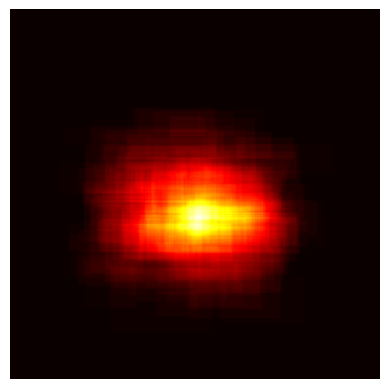

In [13]:
heatmap = np.load('./heatmap.npy')
coords = np.column_stack(np.where(heatmap > 0))
top_left = coords.min(axis=0)
bottom_right = coords.max(axis=0)
plt.imshow(heatmap, cmap='hot')
plt.axis('off')

In [15]:
from utils.vis import draw_bboxes
root_path = 'MLDataset'
crop_data_path = os.path.join(root_path, 'crop_data_enhanced/images')
mode = 'test'
save_path = os.path.join(crop_data_path, mode)

image_files = glob.glob(os.path.join(root_path, image_folder, mode, '**/*.png'), recursive=True)


## Apply histogram matching for each image
for i, image_file in enumerate(image_files):
    print(f"Processing {image_file}")
    ### Parse label
    image = preprocess(image_file)
    image_name = os.path.basename(image_file)
    
    scaled_roi_coords = [top_left[0]/heatmap.shape[0]*image.shape[0], top_left[1]/heatmap.shape[1]*image.shape[1], bottom_right[0]/heatmap.shape[0]*image.shape[0], bottom_right[1]/heatmap.shape[1]*image.shape[1]]
    roi_image = image[int(scaled_roi_coords[0]):int(scaled_roi_coords[2]), int(scaled_roi_coords[1]):int(scaled_roi_coords[3])]
    
    ## Save the cropped image
    class_name = image_file.split('/')[-2]
    os.makedirs(os.path.join(save_path, class_name), exist_ok=True)
    cv2.imwrite(os.path.join(os.path.join(save_path, class_name), image_name), roi_image)
    
    if 'normal' in image_file:
        continue
    label_path = image_file.replace('images', 'labels').replace('.png', '.txt')
    labels = load_yolo_labels(label_path, image.shape, [3]) # 3 is the class index for fracture 
    ## Rescale the labels to cropped image
    new_labels = []
    for label in labels:
        c, *xyxy = label
        x1, y1, x2, y2 = xyxy
        roi_x1, roi_y1, roi_x2, roi_y2 = x1-scaled_roi_coords[1], y1-scaled_roi_coords[0], x2-scaled_roi_coords[1], y2-scaled_roi_coords[0]
        # new_labels.append([c, roi_x1, roi_y1, roi_x2, roi_y2])
        roi_h, roi_w = roi_image.shape
        norm_x1, norm_y1, norm_x2, norm_y2 = roi_x1/roi_w, roi_y1/roi_h, roi_x2/roi_w, roi_y2/roi_h
        norm_xc, norm_yc = (norm_x1 + norm_x2)/2, (norm_y1 + norm_y2)/2
        norm_w, norm_h = norm_x2 - norm_x1, norm_y2 - norm_y1
        new_labels.append([c, norm_xc, norm_yc, norm_w, norm_h])
    
    # draw_bboxes(roi_image, new_labels)
    ## Export new labels
    save_label_path = save_path.replace('images', 'labels')
    os.makedirs(os.path.join(save_label_path, class_name), exist_ok=True)
    new_label_path = os.path.join(save_label_path, class_name, image_name.replace('.png', '.txt'))
    f = open(new_label_path, 'w')
    for label in new_labels:
        f.write(f"{label[0]} {label[1]} {label[2]} {label[3]} {label[4]}\n")
    f.close()

    # _, fig = plt.subplots(1, 2, figsize=(10, 5))
    # fig[0].imshow(image, cmap='gray')
    # fig[0].axis('off')
    # fig[1].imshow(roi_image, cmap='gray')
    # fig[1].axis('off')

Processing MLDataset/images/test/normal/0045_0661159881_01_WRI-L1_M010.png
Processing MLDataset/images/test/normal/0073_1210326335_02_WRI-R1_M017.png
Processing MLDataset/images/test/normal/0087_0493070693_01_WRI-R2_F003.png
Processing MLDataset/images/test/normal/0351_0798024563_01_WRI-R2_M014.png
Processing MLDataset/images/test/normal/0669_0764349986_02_WRI-L1_F013.png
Processing MLDataset/images/test/normal/0019_0224740760_01_WRI-R1_M009.png
Processing MLDataset/images/test/normal/0022_0473957122_03_WRI-R2_M014.png
Processing MLDataset/images/test/normal/0073_1156812570_01_WRI-L2_M015.png
Processing MLDataset/images/test/normal/0074_0778270458_01_WRI-L1_F010.png
Processing MLDataset/images/test/normal/0023_0657842010_02_WRI-L2_M012.png
Processing MLDataset/images/test/normal/0386_0704200329_01_WRI-R2_M012.png
Processing MLDataset/images/test/normal/0048_0915622108_02_WRI-L2_F014.png
Processing MLDataset/images/test/normal/0002_0354485759_01_WRI-R2_F012.png
Processing MLDataset/imag